### Graph Convolutional Networks - Semi-Supervised Learning with Spectral Graph Convolutions

In [101]:
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data_node = pd.read_csv("crm.attributes.csv") 
# Preview the first 5 lines of the loaded data 
print(data_node.head())
print(data_node.tail())

   node churn status
0     0   Won    Won
1     1  Sale    Won
2     2  Sale    Won
3     3  Sale    Won
4     4  Sale    Won
     node churn status
362   362  Sale   Lost
363   363  Sale   Lost
364   364  Sale   Lost
365   365  Sale   Lost
366   366  Sale   Lost


In [102]:
df_admin=data_node.loc[data_node['status'] == 'Won', 'node']
print(df_admin.head())
print(df_admin.tail())

0    0
1    1
2    2
3    3
4    4
Name: node, dtype: int64
263    263
264    264
265    265
266    266
267    267
Name: node, dtype: int64


In [103]:
#list(df_admin.columns)
len(df_admin)

177

In [104]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array

DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_crm_data():
    network = read_edgelist(
        'crm.edgelist',
        nodetype=int)

    attributes = read_csv(
        'crm.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['churn'] == 'Won')
        for node, data in network.nodes(data=True)
        if data['churn'] in {'Won', 'Lost'}
    ]))
    X_test, y_test = map(array, zip(*[
        ([node], data['status'] == 'Won')
        for node, data in network.nodes(data=True)
        if data['churn'] == 'Sale'
    ]))
    
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [105]:
from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length
import mxnet.ndarray as nd

crm = load_crm_data()

A = to_numpy_matrix(crm.network)
A = nd.array(A)

X_train = crm.X_train.flatten()
y_train = crm.y_train
X_test = crm.X_test.flatten()
y_test = crm.y_test

# Layer Implementations

In [106]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [107]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(367, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

# Models

In [108]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

## Model 1: Identity Matrix as Features

In [109]:
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
model_1(X_1)


[[0.3975648 ]
 [0.38546896]
 [0.4064757 ]
 [0.42701364]
 [0.40627488]
 [0.40578178]
 [0.40418792]
 [0.37254858]
 [0.40612093]
 [0.40688792]
 [0.40043604]
 [0.39781335]
 [0.37493366]
 [0.3892631 ]
 [0.3744939 ]
 [0.39655352]
 [0.39899713]
 [0.39511174]
 [0.39602238]
 [0.43007225]
 [0.3550644 ]
 [0.4893552 ]
 [0.39670128]
 [0.39506432]
 [0.39745015]
 [0.40477714]
 [0.41791695]
 [0.41559735]
 [0.4046735 ]
 [0.40851524]
 [0.39228272]
 [0.3231941 ]
 [0.3032365 ]
 [0.39427704]
 [0.3982049 ]
 [0.38511536]
 [0.36105514]
 [0.38496438]
 [0.39043993]
 [0.36995625]
 [0.393069  ]
 [0.3960022 ]
 [0.3995172 ]
 [0.40547782]
 [0.4041031 ]
 [0.4994093 ]
 [0.3752779 ]
 [0.4011011 ]
 [0.33601162]
 [0.3514506 ]
 [0.38895363]
 [0.37184972]
 [0.39126065]
 [0.39972043]
 [0.3913488 ]
 [0.40738118]
 [0.40739304]
 [0.33532527]
 [0.37653545]
 [0.36901745]
 [0.39899302]
 [0.4002099 ]
 [0.4193727 ]
 [0.36515144]
 [0.42727154]
 [0.31253368]
 [0.36385214]
 [0.43543547]
 [0.42744747]
 [0.28402564]
 [0.34678307]
 [0.3

## Model 2: Distance to Administrator and Instructor as Additional Features

In [110]:
X_2 = nd.zeros((A.shape[0], 2))
node_distance_instructor = shortest_path_length(crm.network, target=96)
node_distance_administrator = shortest_path_length(crm.network, target=0)

for node in crm.network.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]

In [111]:
X_2 = nd.concat(X_1, X_2)
model_2, features_2 = build_model(A, X_2)
model_2(X_2)


[[0.7238475 ]
 [0.7342303 ]
 [0.735248  ]
 [0.74197227]
 [0.7376756 ]
 [0.7370484 ]
 [0.7319547 ]
 [0.74149543]
 [0.7334404 ]
 [0.73919207]
 [0.7403576 ]
 [0.7340587 ]
 [0.7415777 ]
 [0.73819155]
 [0.7257945 ]
 [0.72592086]
 [0.72813874]
 [0.727116  ]
 [0.7291352 ]
 [0.7602506 ]
 [0.73666763]
 [0.7254282 ]
 [0.73379254]
 [0.72659254]
 [0.73978204]
 [0.74063927]
 [0.73038715]
 [0.7326614 ]
 [0.7314544 ]
 [0.7362076 ]
 [0.7351213 ]
 [0.7230785 ]
 [0.7116028 ]
 [0.7204931 ]
 [0.7297824 ]
 [0.7323128 ]
 [0.7183072 ]
 [0.7228463 ]
 [0.73242724]
 [0.7259259 ]
 [0.72631985]
 [0.7304161 ]
 [0.72100264]
 [0.72987586]
 [0.7167396 ]
 [0.71076983]
 [0.7152007 ]
 [0.72854865]
 [0.7250839 ]
 [0.71451026]
 [0.71766806]
 [0.7194551 ]
 [0.7291024 ]
 [0.7295071 ]
 [0.7352863 ]
 [0.7397633 ]
 [0.7274026 ]
 [0.73128843]
 [0.7277548 ]
 [0.72782505]
 [0.7482243 ]
 [0.7414168 ]
 [0.7510658 ]
 [0.7436588 ]
 [0.73399323]
 [0.71877176]
 [0.7389708 ]
 [0.7250627 ]
 [0.72758776]
 [0.7238354 ]
 [0.7156352 ]
 [0.7

# Train and Test Models

In [112]:
%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

Wall time: 0 ns


## Performance of Model 1

In [113]:
from sklearn.metrics import classification_report

feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=500)
y_pred_1 = predict(model_1, X_1, X_test)
print(classification_report(y_test, y_pred_1))

Epoch 50/500 -- Loss:  1.3118
[0.49664503, 0.4576827]
Epoch 100/500 -- Loss:  0.9608
[0.65042704, 0.41180056]
Epoch 150/500 -- Loss:  0.3972
[0.7529583, 0.10728304]
Epoch 200/500 -- Loss:  0.1252
[0.89505345, 0.014228458]
Epoch 250/500 -- Loss:  0.0287
[0.9741237, 0.0024480019]
Epoch 300/500 -- Loss:  0.0057
[0.9947866, 0.0004895836]
Epoch 350/500 -- Loss:  0.0011
[0.99899846, 0.00010379579]
Epoch 400/500 -- Loss:  0.0002
[0.9998098, 2.2604798e-05]
Epoch 450/500 -- Loss:  0.0000
[0.9999641, 4.990737e-06]
Epoch 500/500 -- Loss:  0.0000
[0.9999932, 1.1096647e-06]
              precision    recall  f1-score   support

       False       0.43      0.24      0.31       189
        True       0.45      0.66      0.53       176

    accuracy                           0.44       365
   macro avg       0.44      0.45      0.42       365
weighted avg       0.44      0.44      0.42       365



## Performance of Model 2

In [114]:
feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=1000)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))

Epoch 100/1000 -- Loss:  0.5566
[0.5869537, 0.02351596]
Epoch 200/1000 -- Loss:  0.0133
[0.99042445, 0.003687562]
Epoch 300/1000 -- Loss:  0.0013
[0.99995947, 0.0012997492]
Epoch 400/1000 -- Loss:  0.0005
[0.9999999, 0.00046180366]
Epoch 500/1000 -- Loss:  0.0002
[1.0, 0.00016159017]
Epoch 600/1000 -- Loss:  0.0001
[1.0, 5.6084056e-05]
Epoch 700/1000 -- Loss:  0.0000
[1.0, 1.940119e-05]
Epoch 800/1000 -- Loss:  0.0000
[1.0, 6.7040232e-06]
Epoch 900/1000 -- Loss:  0.0000
[1.0, 2.3149328e-06]
Epoch 1000/1000 -- Loss:  0.0000
[1.0, 7.9888605e-07]
              precision    recall  f1-score   support

       False       1.00      0.88      0.94       189
        True       0.88      1.00      0.94       176

    accuracy                           0.94       365
   macro avg       0.94      0.94      0.94       365
weighted avg       0.94      0.94      0.94       365



In [172]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_feature_representations(feature_representations, epoch=None):
    if epoch is None:
        epoch = len(feature_representations) - 1
    s = 200

    embedding = feature_representations[epoch]
    

    graph = crm.network

    # Plot Churn - lost
    lost = {
        node
        for node in graph.nodes()
        if graph.nodes[node]['status'] == 'Lost'
    }

    x, y = zip(*[embedding[node] for node in lost - {96}])
    p1 = plt.scatter(x, y, c='C1', s=s)

    #Plot churn - won
    won = {
        node
        for node in graph.nodes()
        if graph.nodes[node]['status'] == 'Won'
    }

    x, y = zip(*[embedding[node] for node in won - set([0])])
    p2 = plt.scatter(x, y, c='C0', s=s)

    # Plot won and lost sakes Nodes
    p3 = plt.scatter(*embedding[0], c='C0', s=s*1.5)
    plt.annotate('W', xy=embedding[0], ha='center', va='center')

    p4 = plt.scatter(*embedding[96], c='C1', s=s*1.5)
    plt.annotate('L', xy=embedding[96], ha='center', va='center')
    plt.title(f'Epoch {epoch}')
    
    return (p1, p2, p3, p4)

In [173]:
from networkx import (
    spring_layout, draw_networkx_nodes, draw_networkx_edges, draw_networkx_labels
)
import matplotlib.pyplot as plt

def visualize_errors(model, X, X_train, y_train, X_test, y_test):
    preds = model(X).asnumpy().flatten()
    preds = np.where(preds >= 0.5, 1, 0)

    y_full = np.zeros(34)
    for i, value in enumerate(X_train):
        y_full[value] = y_train[i]
    for i, value in enumerate(X_test):
        y_full[value] = y_test[i]


    correct = np.equal(preds, y_full)

    incorrect_nodes = [
        node for node in crm.network.nodes()
        if correct[node] == 0
    ]
    print(incorrect_nodes)
    print(X[incorrect_nodes])

    correct_sales_lost_nodes = [
        node for node, data in crm.network.nodes(data=True)
        if correct[node] == 1 and data['status'] == 'Lost' and node != 96
    ]

    correct_sale_won_nodes = [
        node for node, data in crm.network.nodes(data=True)
        if correct[node] == 1 and data['status'] == 'Won' and node != 0
    ]

    pos = spring_layout(crm.network)

    won = set(
        n -1 for n in df_admin)
    lost = set(node for node in crm.network.nodes() if node not in won)


    node_colors = {
        'C0' if node in won else 'C1'
    }
    
    for nodes, color in [(incorrect_nodes, 'k'),
                         (correct_sale_won_nodes, 'C0'),
                         (correct_sales_lost_nodes, 'C1')
                        ]:
        draw_networkx_nodes(crm.network, pos, nodelist=nodes, node_color=color)


    draw_networkx_edges(crm.network, pos,width=1.0,alpha=0.5)
    draw_networkx_nodes(crm.network, pos, nodelist=[0], node_size=300, node_color='C0')
    draw_networkx_nodes(crm.network, pos, nodelist=[96], node_size=300, node_color='C1')

    labels = {96: 'L', 0: 'W'}
    draw_networkx_labels(crm.network, pos, labels, font_size=8)  #network

    plt.axis('off')

### Model - 1 ( with identity metrix as feature)

(<matplotlib.collections.PathCollection object at 0x000002769F4669E8>, <matplotlib.collections.PathCollection object at 0x000002769B58CC50>, <matplotlib.collections.PathCollection object at 0x000002769F466BE0>, <matplotlib.collections.PathCollection object at 0x000002769F466160>)


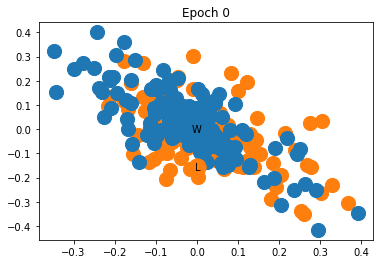

In [174]:
d = visualize_feature_representations(feature_representations_1, epoch=0)
print(d)
plt.show()

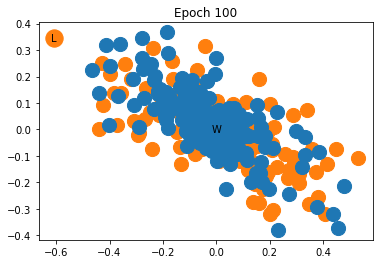

In [175]:
visualize_feature_representations(feature_representations_1, epoch=100)
plt.show()

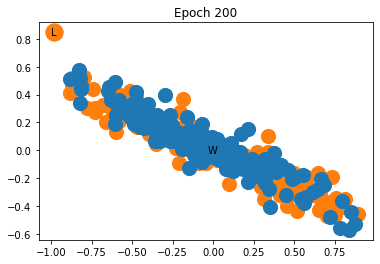

In [176]:
visualize_feature_representations(feature_representations_1, epoch=200)
plt.show()

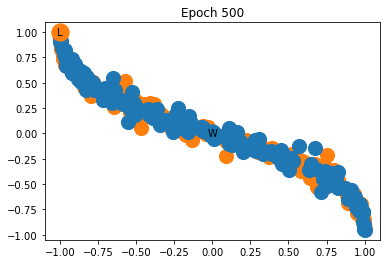

In [177]:
visualize_feature_representations(feature_representations_1)
plt.show()

### Model-2 ( Shortest path as graph feature)

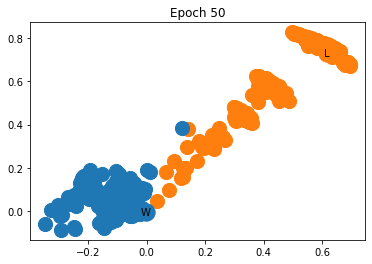

In [178]:
visualize_feature_representations(feature_representations_2, epoch=50)
plt.show()

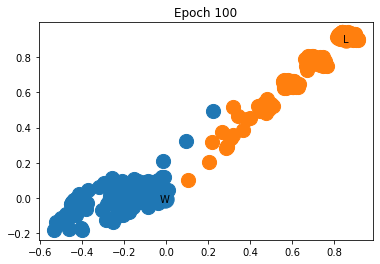

In [179]:
visualize_feature_representations(feature_representations_2, epoch=100)
plt.show()

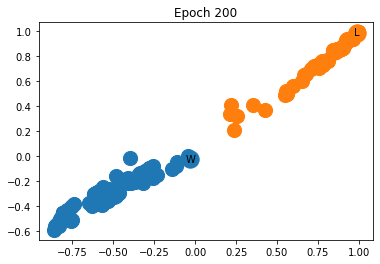

In [180]:
visualize_feature_representations(feature_representations_2, epoch=200)
plt.show()

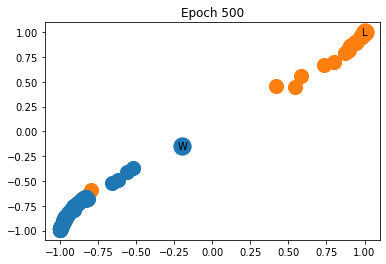

In [181]:
visualize_feature_representations(feature_representations_2, epoch=500)
plt.show()

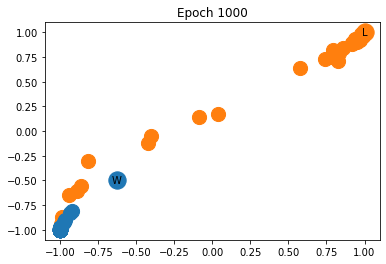

In [182]:
visualize_feature_representations(feature_representations_2)
plt.show()